__Cash Ratio Optimization__

Kurangnya efisiensi dalam pengelolaan uang tunai yang beredar di lapangan, baik di unit kerja, mesin CRM  dan mesin ATM  meningkatkan biaya operasional dan hilangnya potensi penggunaan uang tunai untuk bisnis perbankan BRI.

Dalam kategori use case Cash Ratio Optimization, peserta diminta untuk membangun model berbasiskan Machine Learning yang dapat memberikan rekomendasi pengelolaan uang tunai dengan akurat sehingga diharapkan mampu menekan biaya operasional dan mengurangi hilangnya kesempatan bisnis BRI dalam penggunaan uang tunai.

__Task__

Menggunakan data yang ada, prediksi nilai kas_kantor dan kas_echannel untuk 31 hari kedepan , dimana nilai kas_kantor dan kas_echannel untuk waktu t didefiniskan sebagai berikut:

\[ kas\_kantor_{t} = kas\_kantor_{t-1} + cash\_in\_kantor_{t} + cash\_out\_kantor_{t} \]

\[ kas\_echannel_{t} = kas\_echannel_{t-1} + cash\_in\_echannel_{t} + cash\_out\_echannel_{t} \]


__Import Library__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import STL
import statsmodels.tsa.api as smt

__Load Data__

In [2]:
train = pd.read_csv('C:/Users/lenovo/Pictures/BRI Data Hackhaton/bri-data-hackathon-cr-optimization/train.csv', index_col=[0], parse_dates=[0])

In [3]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2019-07-31 to 2020-09-30
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cash_in_echannel            425 non-null    float64
 1   cash_out_echannel           425 non-null    float64
 2   cash_in_kantor              425 non-null    float64
 3   cash_out_kantor             425 non-null    float64
 4   cr_ketetapan_total_bkn_sum  425 non-null    float64
 5   giro                        425 non-null    float64
 6   deposito                    425 non-null    float64
 7   kewajiban_lain              425 non-null    float64
 8   tabungan                    425 non-null    float64
 9   rata_dpk_mingguan           425 non-null    float64
 10  kas_kantor                  425 non-null    float64
 11  kas_echannel                425 non-null    float64
dtypes: float64(12)
memory usage: 43.2 KB


,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
periode,,,,,,,,,,,,
2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


In [4]:
info = pd.read_csv('C:/Users/lenovo/Pictures/BRI Data Hackhaton/bri-data-hackathon-cr-optimization//data_description.csv')
pd.set_option('display.max_colwidth', -1)
info

,variabel,sample Data,Deskripsi
0,cash_in_echannel,7.924471e+09,Total Kas Masuk pada kas eChannel (ATM dan CRM)
1,cash_out_echannel,7.924471e+09,Total Kas keluar pada kas eChannel (ATM dan CRM)
2,cash_in_kantor,1.372300e+10,Total kas masuk pada kas kantor
3,cash_out_kantor,-2.767644e+10,Total kas keluar pada kas kantor
4,cr_ketetapan_total_bkn_sum,4.350000e+00,Maksimum cash ratio yang dii tetapkan kantor pusat
5,giro,5.355247e+10,Total simpanan giro
6,deposito,1.344615e+10,Total simpanan deposito
7,kewajiban_lain,3.490872e+09,"Simpanan selain giro tabungan dan deposito ,salah satunya adalah surat berharga yang diterbitkan"
8,tabungan,1.659893e+11,Total simpanan tabungan
9,rata_dpk_mingguan,2.401906e+11,rata - rata saldo DPK mingguan


In [5]:
# remove constant variable
train.drop(['cr_ketetapan_total_bkn_sum'], axis=1, inplace=True)

__Show Raw Data__

In [6]:
# plot time series and the corresponding distribution
def plot_all(df):
    cols = df.columns
    fig, ax = plt.subplots(len(cols), 2, figsize=(18,len(cols)*3), gridspec_kw={'width_ratios': [1, 3]})
    colors = sns.color_palette()
    colors += colors
    ylims = [1.8e-9, 1.8e-9, 1.2e-11, 1.4e-11, 1.75e-12, 7e-12, 2.3e-10, 1.3e-11, 1.3e-11, 1.1e-13, 6.5e-10]
    for i, (col, ylim) in enumerate(zip(cols, ylims)):
        sns.distplot(df[col], ax=ax[i,0], color=colors[i])
        ax[i,1].plot(df.index, df[col], color=colors[i])
        ax[i,1].set_title(col)
        ax[i,1].grid()
        ax[i,0].set_ylim(0,ylim)
    plt.tight_layout()

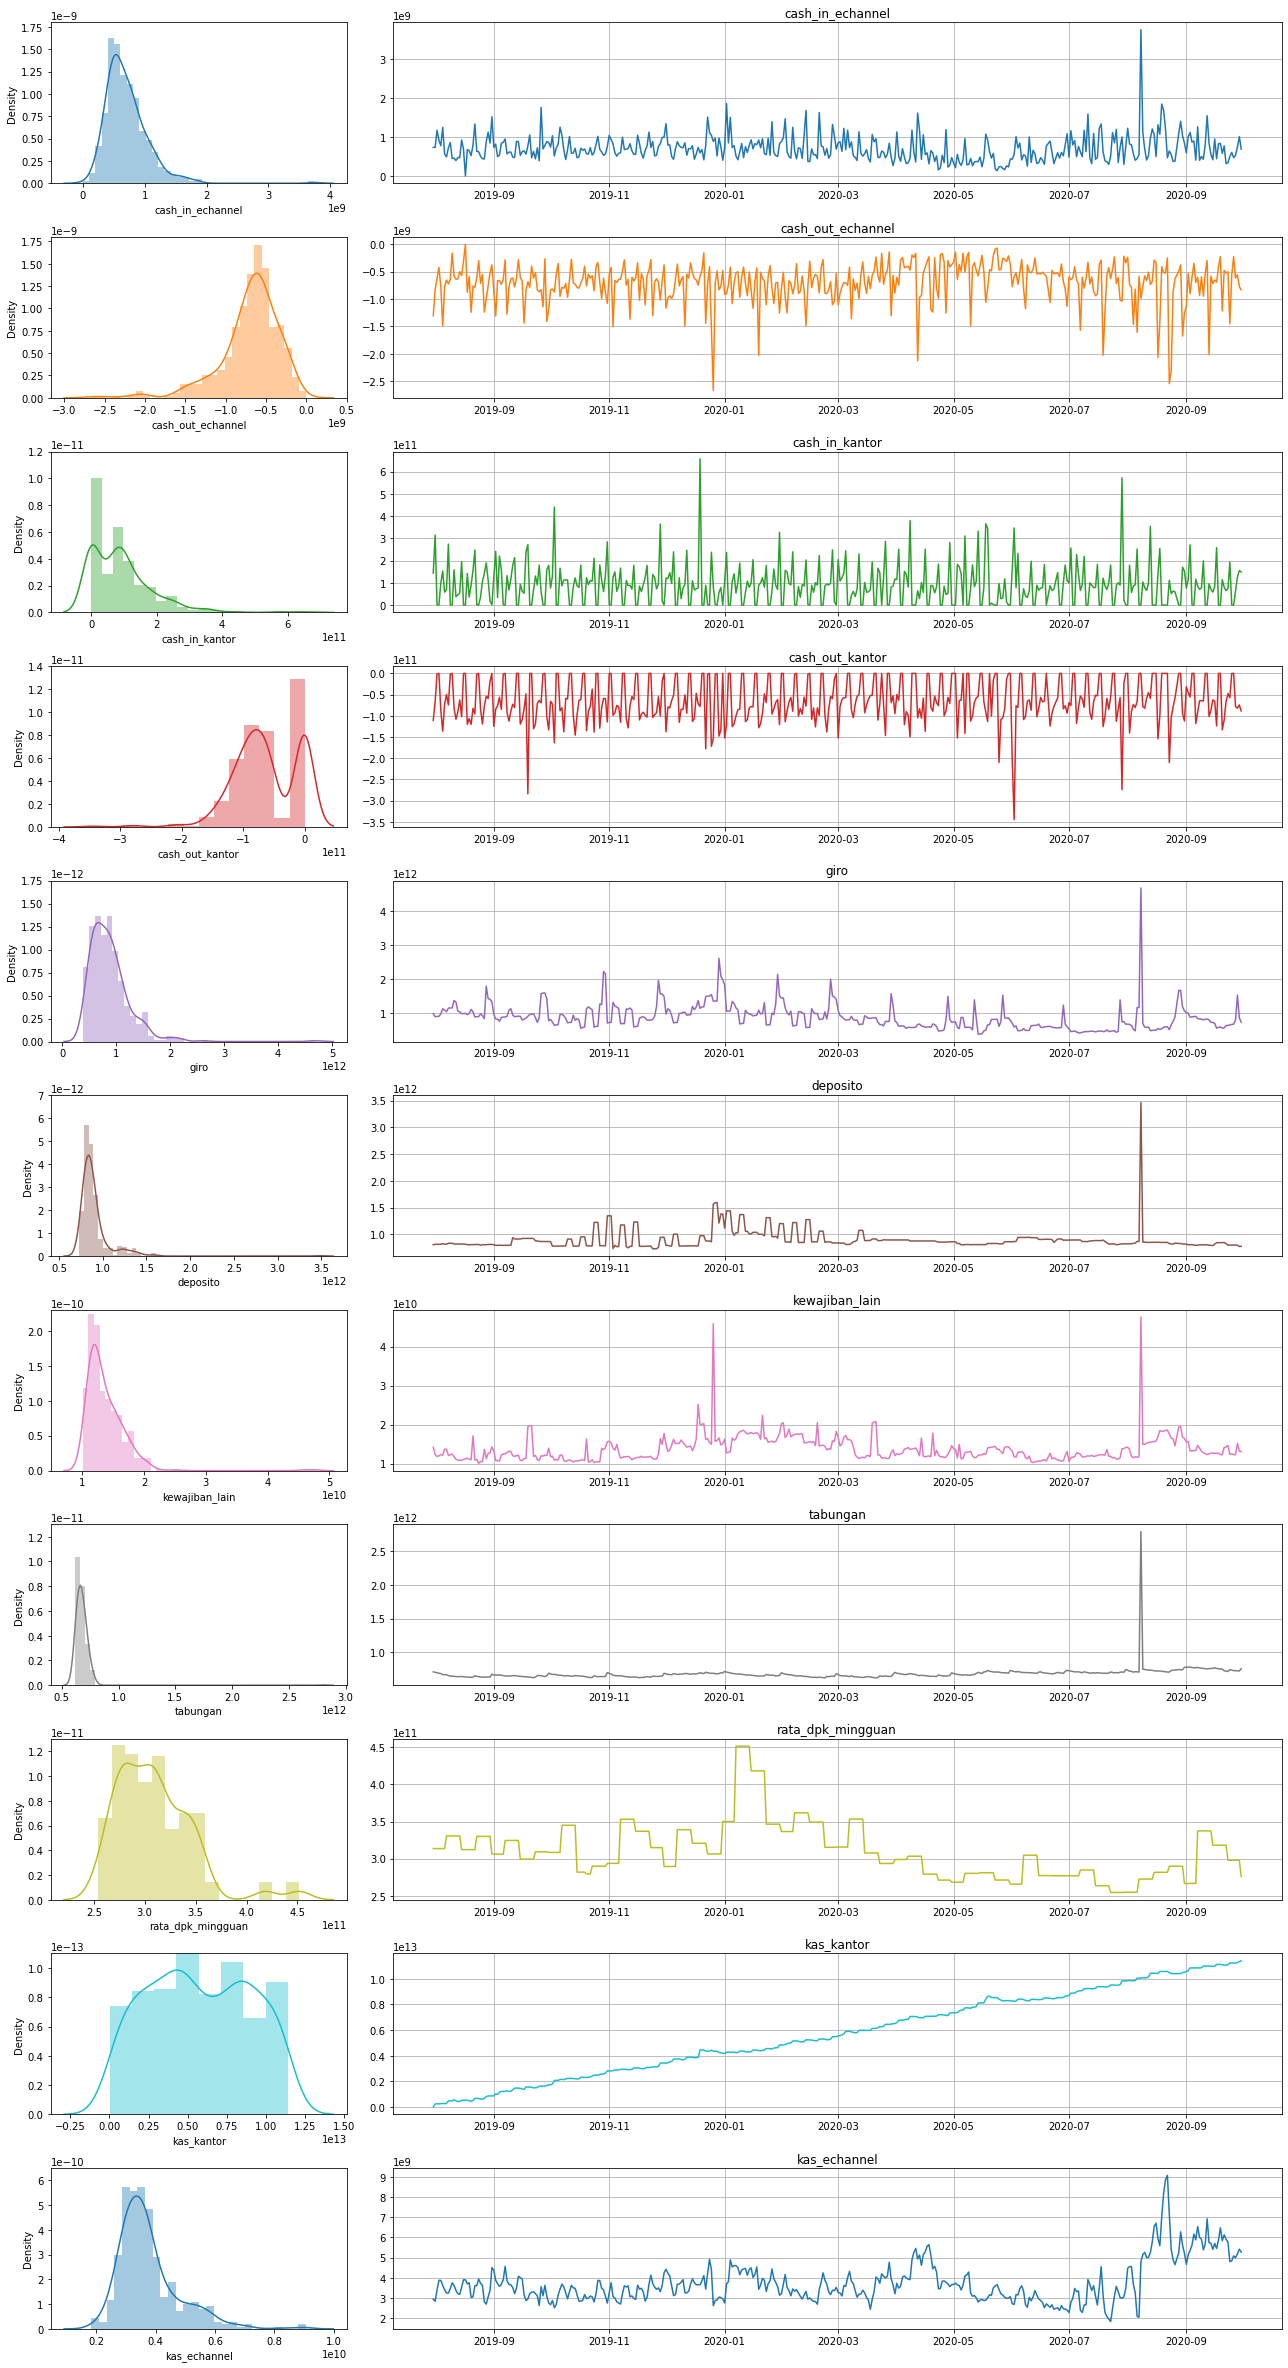

In [7]:
plot_all(train)

__Target Check__

In [8]:
def check(target):
    tmp1 = train[f'cash_in_{target}'] + train[f'cash_out_{target}'] + train[f'kas_{target}'].shift(1)
    tmp2 = train[f'cash_in_{target}'] + train[f'cash_out_{target}']

    fig, ax = plt.subplots(1, 2, figsize=(18,3))
    ax[0].plot(tmp1, label='tmp1')
    ax[0].plot(train[f'kas_{target}'], label=f'kas_{target}')
    ax[0].legend()
    ax[1].plot(tmp2, label='tmp2')
    ax[1].legend();

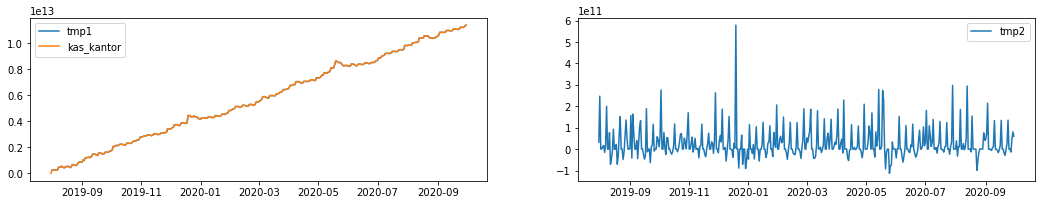

In [9]:
check('kantor')

__Matrix Correlation__

In [10]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
cash_in_echannel,1.00,-0.21,-0.00,0.08,0.29,0.37,0.35,0.43,0.07,-0.02,0.25
cash_out_echannel,-0.21,1.00,-0.36,0.50,-0.13,-0.03,-0.21,-0.05,-0.08,0.04,0.04
cash_in_kantor,-0.00,-0.36,1.00,-0.65,-0.03,-0.09,-0.03,-0.03,-0.05,-0.03,-0.16
cash_out_kantor,0.08,0.50,-0.65,1.00,-0.05,0.15,0.01,0.06,-0.02,0.06,0.13
giro,0.29,-0.13,-0.03,-0.05,1.00,0.34,0.44,0.38,0.21,-0.34,-0.05
deposito,0.37,-0.03,-0.09,0.15,0.34,1.00,0.53,0.59,0.24,-0.05,-0.06
kewajiban_lain,0.35,-0.21,-0.03,0.01,0.44,0.53,1.00,0.48,0.23,0.08,0.21
tabungan,0.43,-0.05,-0.03,0.06,0.38,0.59,0.48,1.00,-0.16,0.31,0.19
rata_dpk_mingguan,0.07,-0.08,-0.05,-0.02,0.21,0.24,0.23,-0.16,1.00,-0.43,0.04
kas_kantor,-0.02,0.04,-0.03,0.06,-0.34,-0.05,0.08,0.31,-0.43,1.00,0.39


__Missing Data__

In [11]:
start = train.index[0]
end = train.index[-1]
ll = pd.date_range(start, end).tolist()
missing = [(i,j) for i,j in enumerate(ll) if j not in train.index]
missing

[(325, Timestamp('2020-06-20 00:00:00', freq='D')),
 (329, Timestamp('2020-06-24 00:00:00', freq='D')),
 (393, Timestamp('2020-08-27 00:00:00', freq='D'))]

In [12]:
# impute missing dates with middle values
for d in missing:
    # get middle value between 2 data
    tmp = (train.iloc[d[0]] + train.iloc[d[0]-1]) / 2
    # give timestamp for the index
    tmp.name = d[1]
    # append new data into the dataframe
    train = train.append(tmp)
train.sort_index(inplace=True)



__Outliners__

In [14]:
def replace_outliers(df, cols, std_thres):
    new_df = df.copy()
    for col in cols:
        global_std = new_df[col].std()
        global_med = new_df[col].median()
        # thresholds
        thres_up = global_med + std_thres*global_std
        thres_dw = global_med - std_thres*global_std
        # get middle values (y(t-1) + y(t+1)) / 2
        new_df['mid'] = (new_df[col].shift(-1) + new_df[col].shift(1)) / 2
        new_df['mid'][0] = new_df['mid'][1]
        new_df['mid'][-1] = new_df['mid'][-2]
        # replace outliers with middle values
        new_df[col] = np.where(new_df[col] > thres_up, new_df['mid'], new_df[col])
        new_df[col] = np.where(new_df[col] < thres_dw, new_df['mid'], new_df[col])
    return new_df.drop(['mid'], axis=1)

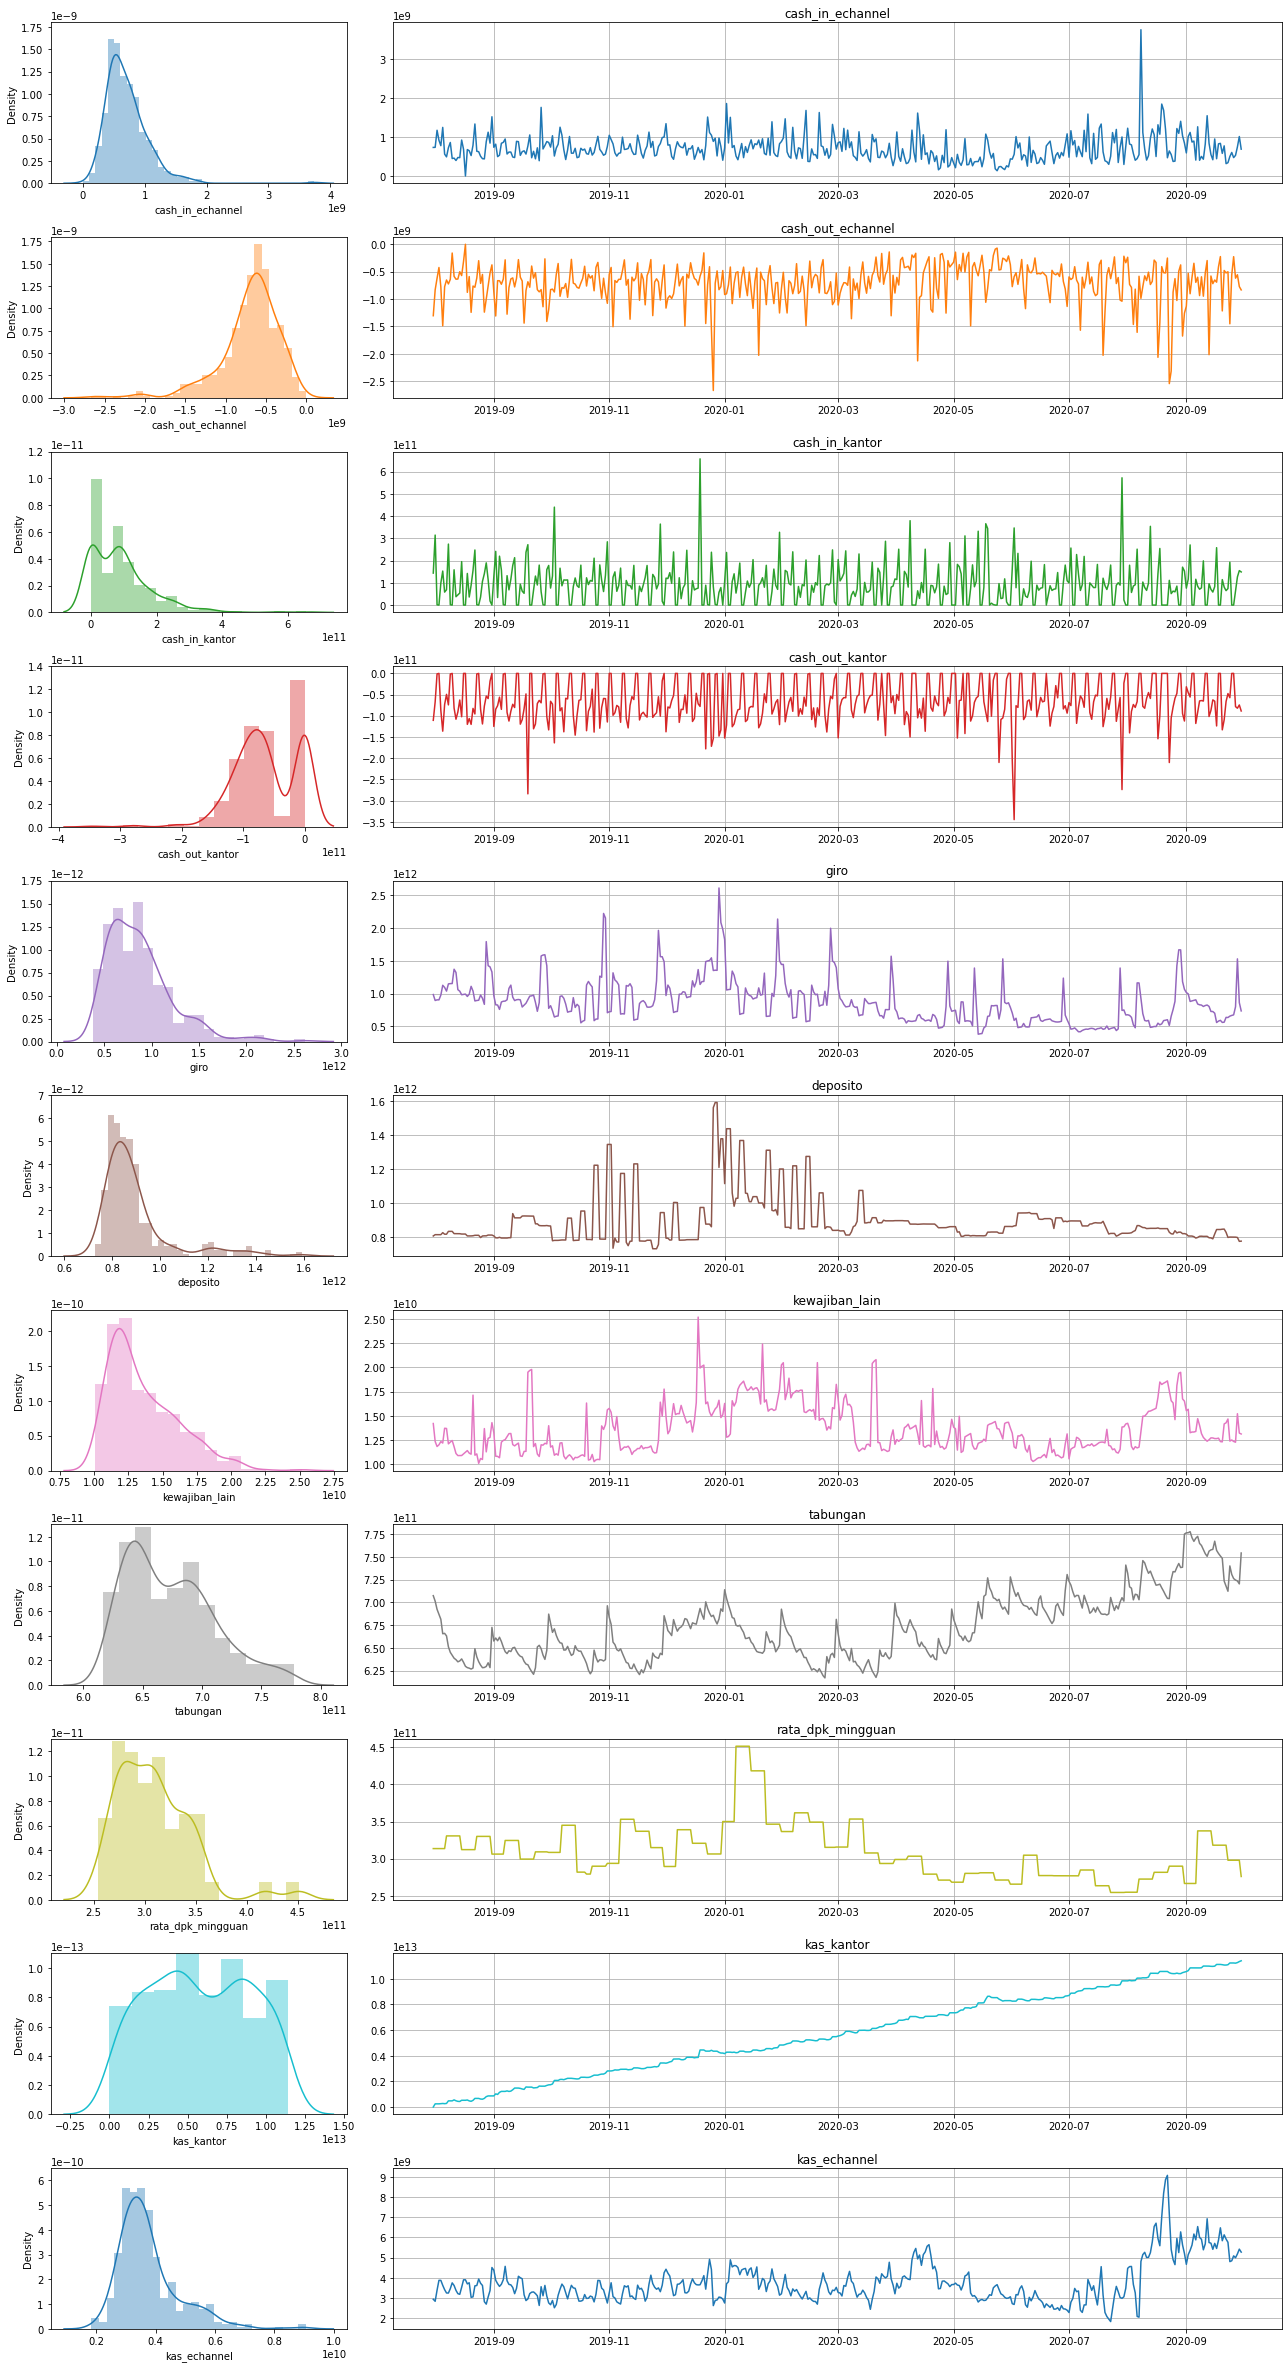

In [15]:
cols = ['giro', 'deposito', 'kewajiban_lain', 'tabungan']
new_train = replace_outliers(train, cols, std_thres=8)
plot_all(new_train)

__Decomposition__

In [16]:
def decompose(df, col):
    stl = STL(df[col])
    result = stl.fit()
    fig, ax = plt.subplots(2, 2, figsize=(18,6))
    colors = sns.color_palette('deep')
    ax[0,0].plot(df[col], label='Original Series', color=colors[0])
    ax[0,0].plot(result.trend + result.seasonal, label='trend + seasonality', color='red')
    ax[0,0].legend()
    ax[0,1].plot(result.trend, color=colors[2]); ax[0,1].set_title('Trend')
    ax[1,0].plot(result.seasonal, color=colors[4]); ax[1,0].set_title('Seasonality')
    mu, std = np.mean(result.resid), np.std(result.resid)
    up, dw = mu + 3*std, mu - 3*std
    ax[1,1].plot(result.resid, color=colors[1]); ax[1,1].set_title('Residual')
    ax[1,1].fill_between(train.index, dw, up, color='g', alpha=0.1)
    for i in range(2): 
        for j in range(2): 
            ax[i,j].grid()
    plt.tight_layout()

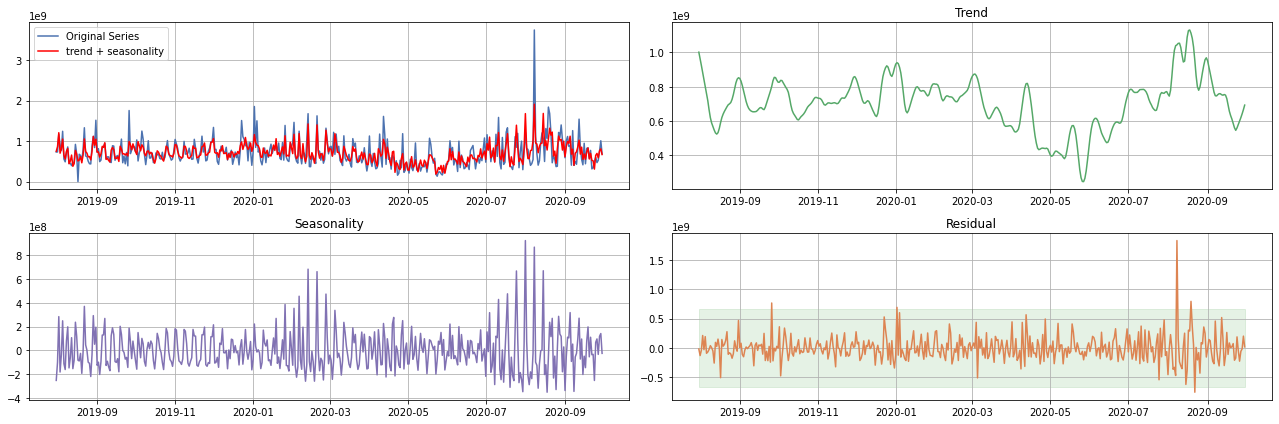

In [17]:
decompose(new_train, 'cash_in_echannel')

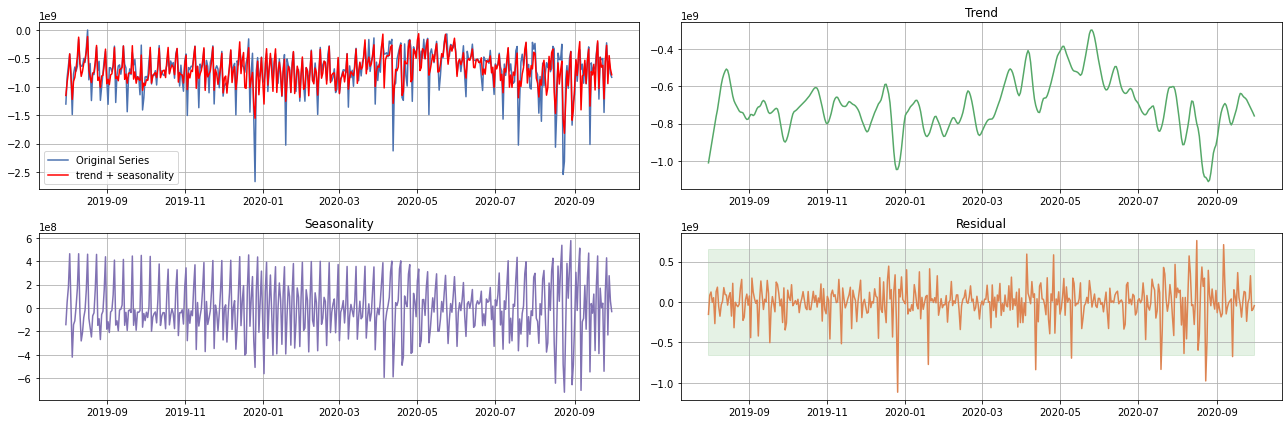

In [18]:
decompose(new_train, 'cash_out_echannel')

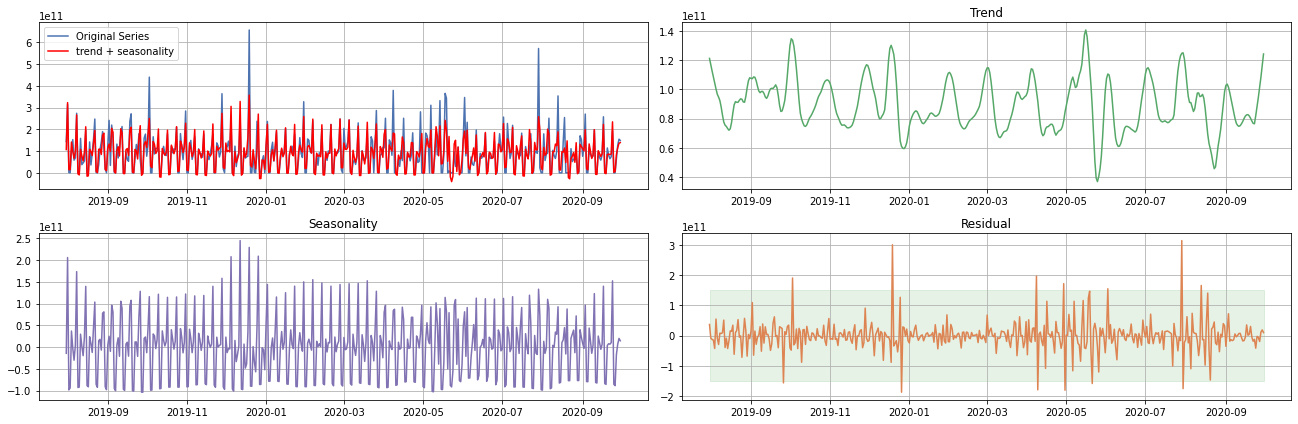

In [19]:
decompose(new_train, 'cash_in_kantor')

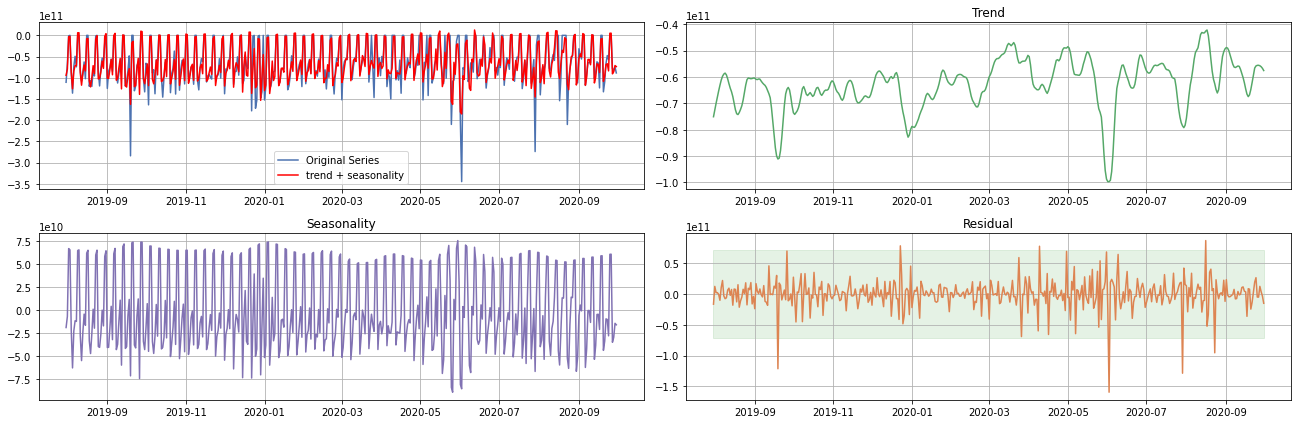

In [20]:
decompose(new_train, 'cash_out_kantor')

__2019 vs 2020 (Aug-Sept)__

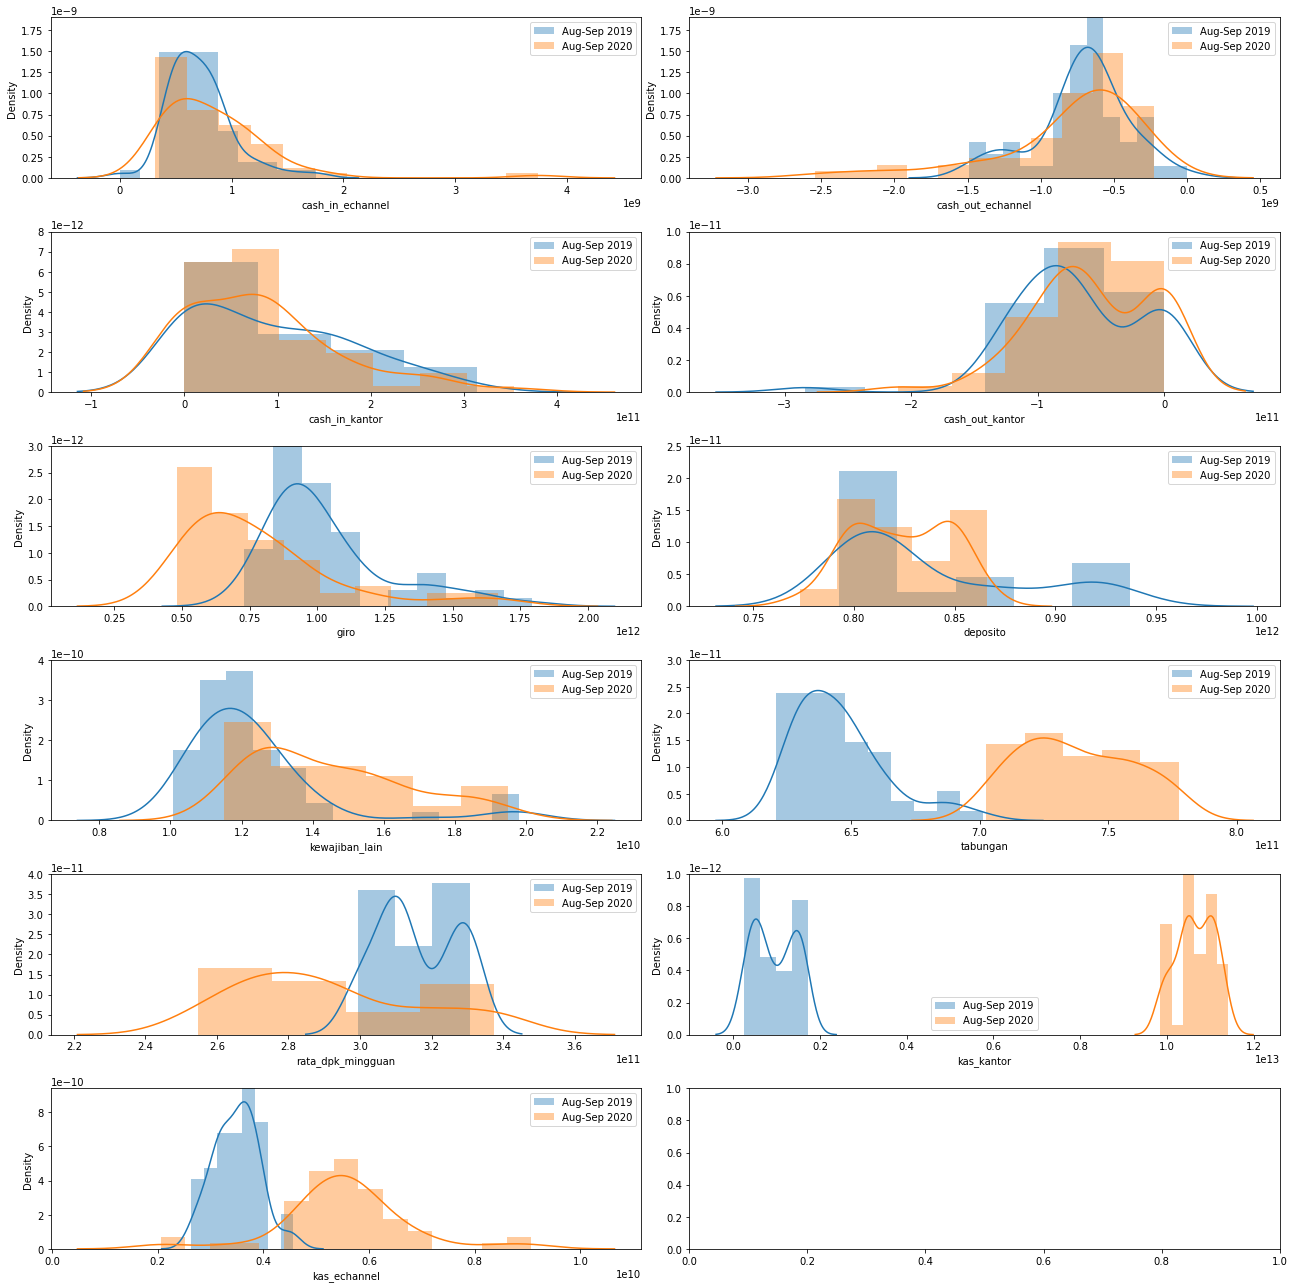

In [21]:
cols = new_train.columns
size = len(cols)
rows = int(np.ceil(size/2))

fig, ax = plt.subplots(rows, 2, figsize=(18,3*rows))
ylims = [1.9e-9, 1.9e-9, .8e-11, 1e-11, 3e-12, 2.5e-11, 4e-10, 3e-11, 4e-11, 1e-12, 9.4e-10]

k = 0
for i in range(rows):
    for j in range(2):
        if k==size:
            break
        col = cols[k]
        for l, t in enumerate(['2019', '2020']):
            filter_ = (new_train.index >= f'{t}-08-01') & (new_train.index < f'{t}-10-01')
            y = new_train[filter_][col]
            sns.distplot(y, label=f'Aug-Sep {t}', ax=ax[i,j])
        ax[i,j].legend()
        ax[i,j].set_ylim(0,ylims[k])

        k += 1
    
plt.tight_layout();

__Weekly Seasonality__

In [22]:
new_train['day_of_week'] = new_train.index.dayofweek
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ddays = {k:v for k,v in zip(range(7),days)}
new_train['day_of_week'] = new_train['day_of_week'].map(ddays)

In [23]:
new_train['day_of_week'].tail()


periode
2020-09-26    Sat
2020-09-27    Sun
2020-09-28    Mon
2020-09-29    Tue
2020-09-30    Wed
Name: day_of_week, dtype: object

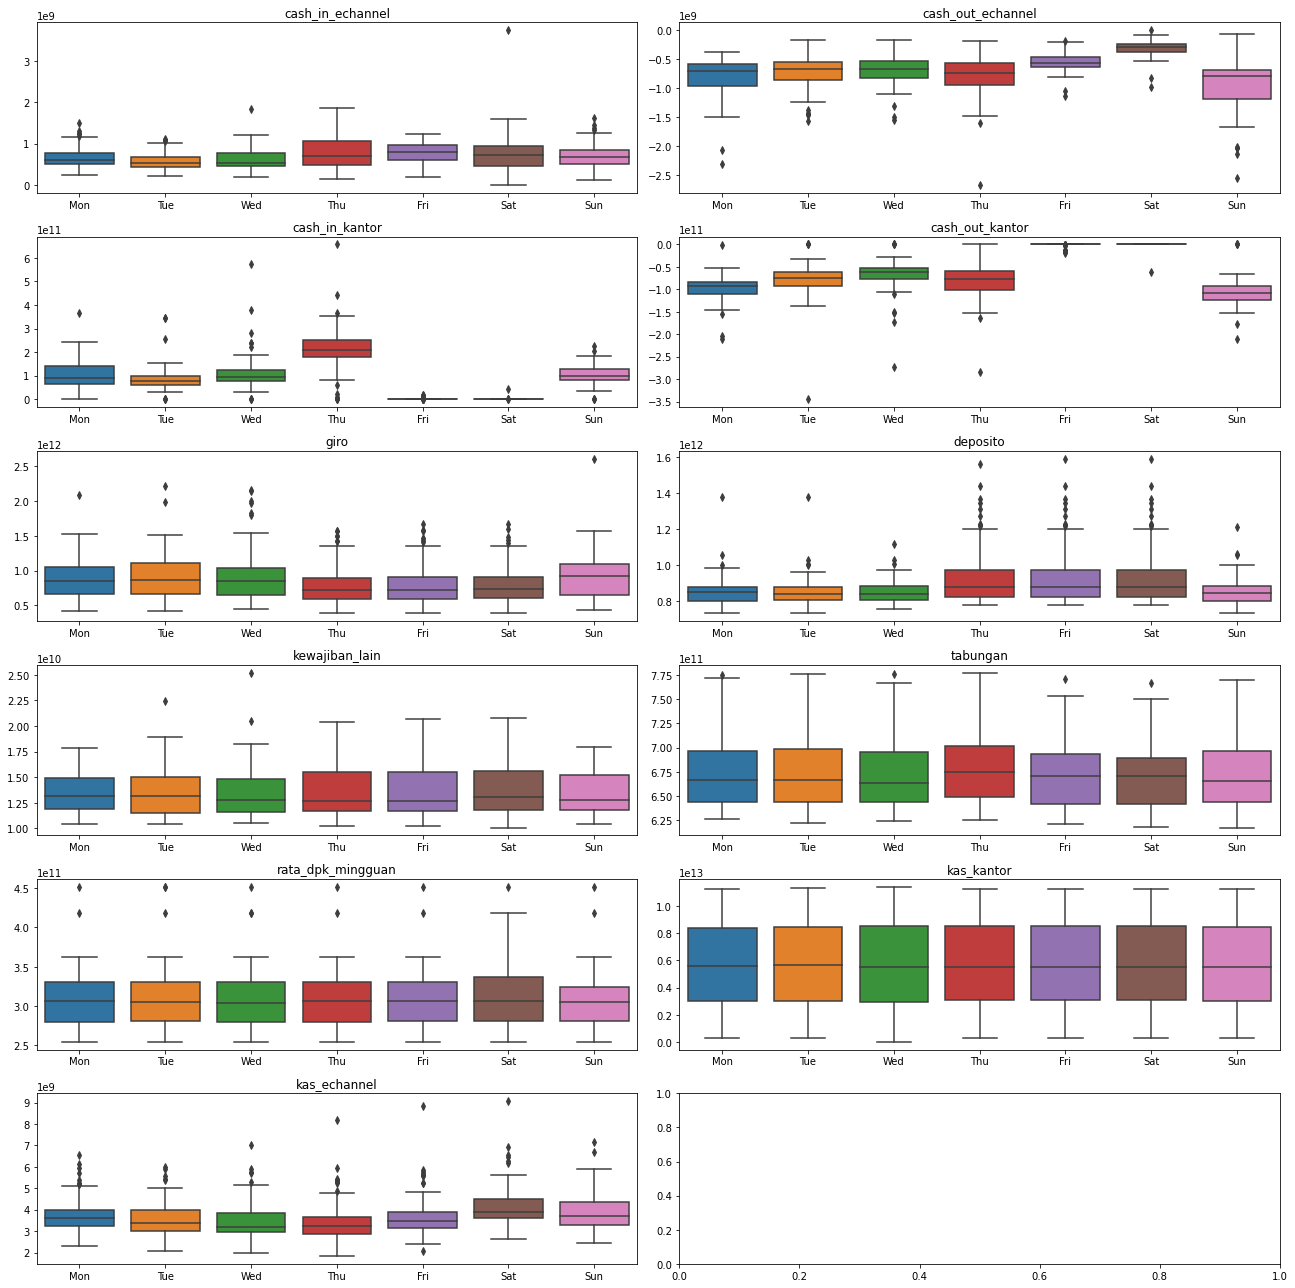

In [24]:
cols = new_train.columns[:11]
size = len(cols)
rows = int(np.ceil(size/2))

fig, ax = plt.subplots(rows, 2, figsize=(18,3*rows))

k = 0
for i in range(rows):
    for j in range(2):
        if k==size:
            break
        col = cols[k]
        x = new_train['day_of_week']
        y = new_train[col]
        sns.boxplot(x, y, ax=ax[i,j], order=days)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].set_title(col)
        k += 1
plt.tight_layout();

__Sationary Check__

In [25]:
def test_stationarity(y, cf_lags=40):
    # Augmented Dickey-Fuller test:
    dftest = smt.adfuller(y)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    # uselful plots
    fig, ax = plt.subplots(3, 2, figsize=(18,10))
    colors = sns.color_palette()
    ax[0,0].plot(y, color=colors[2])
    ax[0,0].set_title('Time Series')
    ax[0,1].hist(y, 40, color=colors[1], alpha=0.75)
    ax[0,1].set_title('Histogram')
    smt.graphics.plot_acf(y, lags=cf_lags, ax=ax[1,0], color=colors[9])
    ax[1,0].set_title('Autocorrelation Function')
    smt.graphics.plot_pacf(y, lags=cf_lags, ax=ax[1,1], color=colors[3])
    ax[1,1].set_title('Partial Autocorrelation Function')
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    M_std = y.groupby(y.index.month).std()
    sns.barplot(months, M_std, ax=ax[2,0], color=colors[4])
    ax[2,0].set_title('Monthly Standard Deviation')
    M_avg = y.groupby(y.index.month).mean()
    sns.barplot(months, M_avg, ax=ax[2,1], color=colors[6])
    ax[2,1].set_title('Monthly Mean Value')
    plt.tight_layout()

    
    

* __cash_in_echannel__

Test Statistic                -8.932466e+00
p-value                        9.731487e-15
#Lags Used                     1.300000e+01
Number of Observations Used    4.130000e+02
Critical Value (1%)           -3.446283e+00
Critical Value (5%)           -2.868564e+00
Critical Value (10%)          -2.570511e+00
dtype: float64


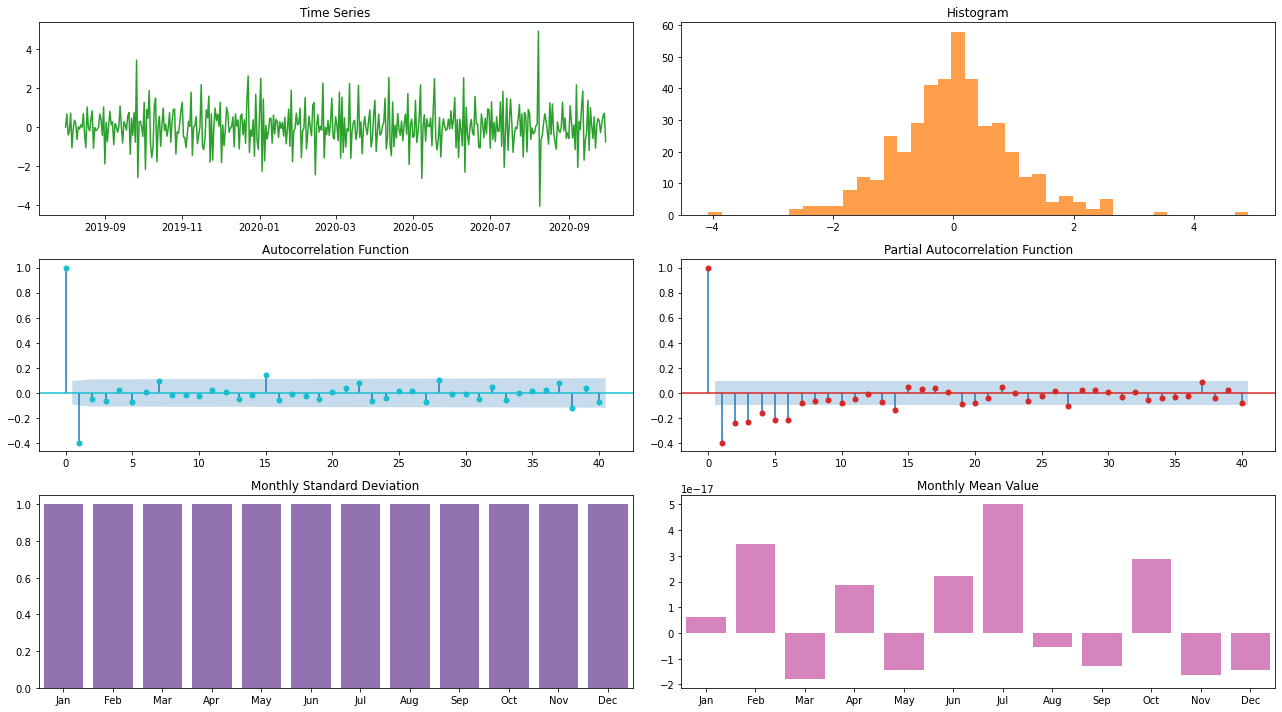

In [26]:
# remove trend
y = new_train['cash_in_echannel'].diff(1).dropna()
# get series with invariant std
M_std = y.groupby(y.index.month).std()
y = y / y.index.map(lambda x: M_std.loc[x.month])
# get series with zero mean
M_mu = y.groupby(y.index.month).mean()
y = y - y.index.map(lambda x: M_mu.loc[x.month])
# test
test_stationarity(y)